🔧 CONFIGURATION / CONFIGURACIÓN
✅ ENGLISH: Current directory / Directorio actual: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks
✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\figures
✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados
✅ ENGLISH: Using device / Usando dispositivo: cpu

📂 ENGLISH: Loading M5 dataset...
📂 ESPAÑOL: Cargando dataset M5...
✅ ENGLISH: Dataset found / Dataset encontrado: ../data/processed/m5_top3_multivariate.csv
✅ ENGLISH: Dataset shape / Dimensiones: (1458, 14)
✅ ESPAÑOL: Productos / Products: ['FOODS_3_090_CA_3_validation', 'FOODS_3_586_TX_2_validation', 'FOODS_3_586_TX_3_validation']

🎯 ENGLISH: Selecting top product...
🎯 ESPAÑOL: Seleccionando producto top...
✅ ENGLISH: Product selected / Producto seleccionado: FOODS_3_090_C

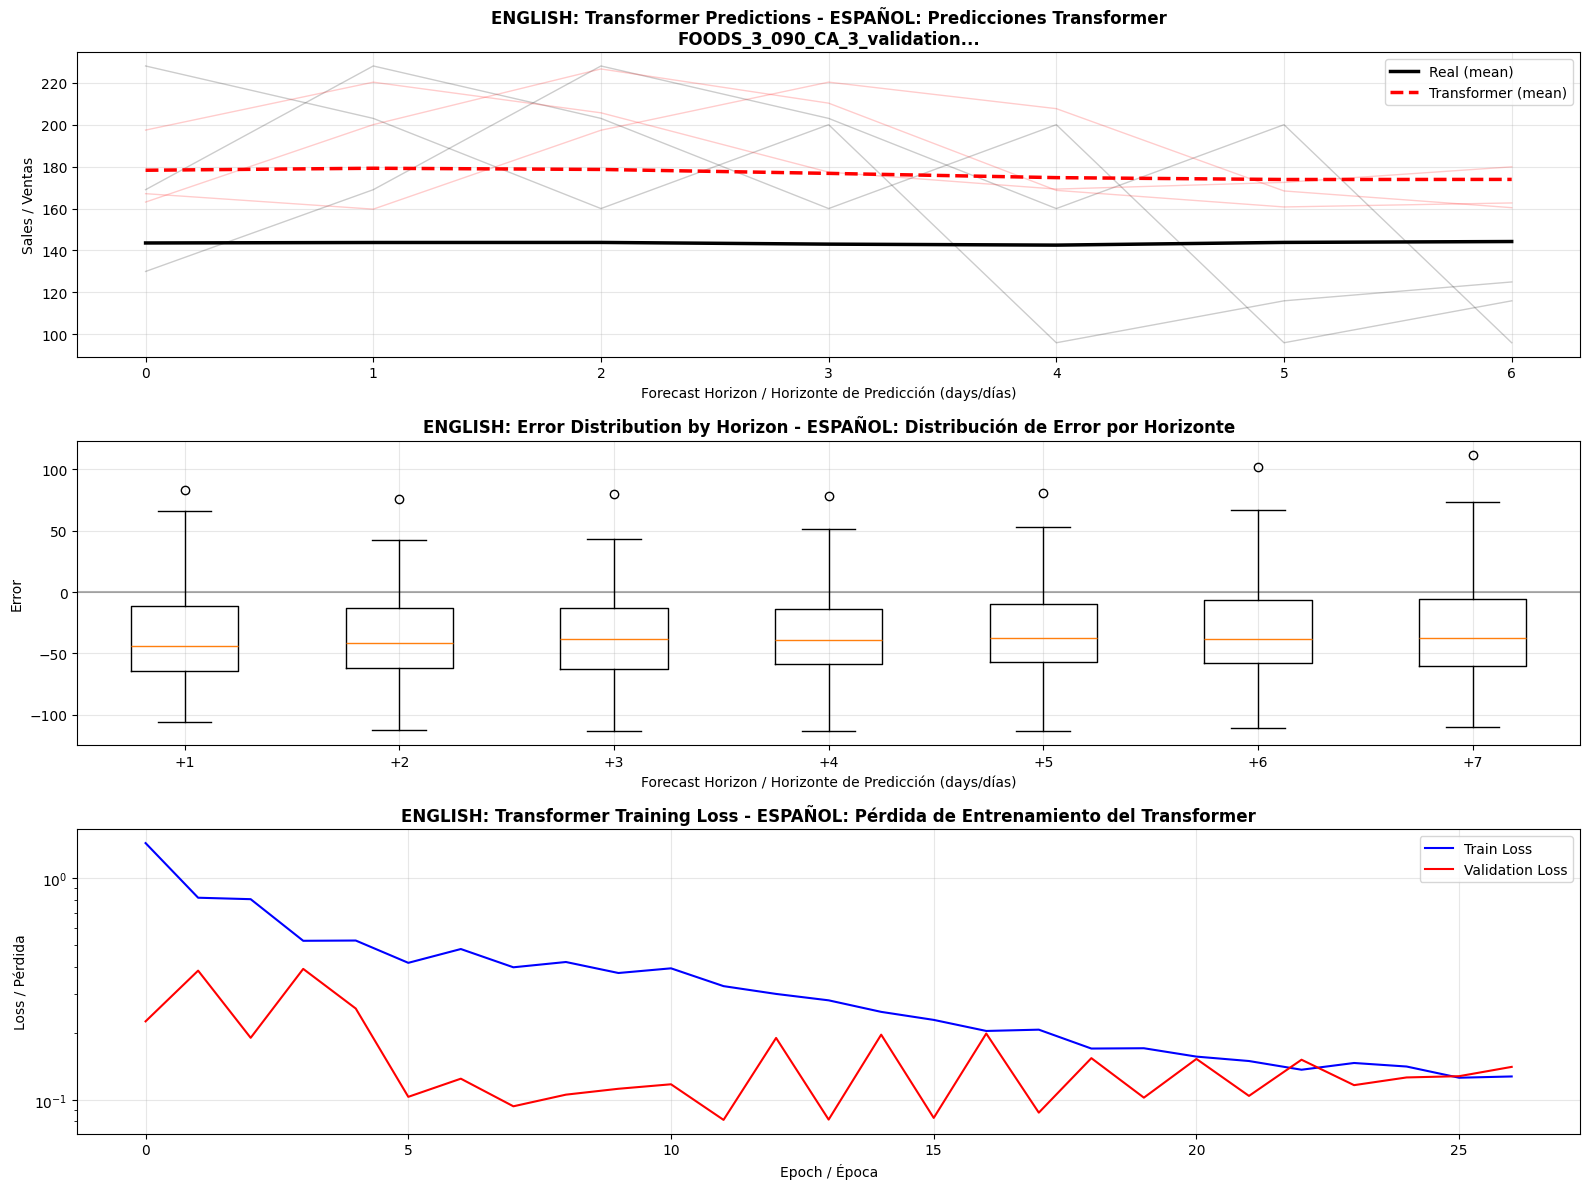


💾 ENGLISH: Saving results...
💾 ESPAÑOL: Guardando resultados...
✅ ENGLISH: Results saved / Resultados guardados: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\17_transformer_results.csv
✅ ESPAÑOL: Copia guardada / Copy saved: 17_transformer_results.csv
✅ ENGLISH: Model saved / Modelo guardado: c:\Users\braya\Documents\E-COMMERCE RESEARCH\aurex-demand-forecasting\notebooks\resultados\17_transformer_model.pth

🎯 ENGLISH: TRANSFORMER EXPERIMENT COMPLETED SUCCESSFULLY
🎯 ESPAÑOL: EXPERIMENTO TRANSFORMER COMPLETADO EXITOSAMENTE

📊 ENGLISH: Transformer Model Results
📊 ESPAÑOL: Resultados del Modelo Transformer

✅ METRICS / MÉTRICAS:
   ├── MAE Test:  42.97
   ├── RMSE Test: 49.95
   ├── MAPE Test: 37.67%
   └── Bias/Sesgo: 32.92

📁 ENGLISH: Files generated / Archivos generados:
   ├── 📊 Results / Resultados: 17_transformer_results.csv
   ├── 🤖 Model / Modelo: 17_transformer_model.pth
   └── 🖼️  Plot / Gráfica: 17_transformer_results_FOODS_3_09.png

In [2]:
# ============================================================
# NOTEBOOK 17: Time Series Transformer - CORREGIDO
# ============================================================
# ENGLISH: State-of-the-art model with self-attention mechanism
# ESPAÑOL: Modelo state-of-the-art con mecanismo de auto-atención
# ============================================================

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import warnings
import os
import glob
warnings.filterwarnings('ignore')

# ============================================================
# CONFIGURATION / CONFIGURACIÓN
# ============================================================
print("="*60)
print("🔧 CONFIGURATION / CONFIGURACIÓN")
print("="*60)

NOTEBOOK_DIR = os.getcwd()
PROJECT_ROOT = os.path.dirname(NOTEBOOK_DIR)

# 🟢 SAME SYSTEM AS NOTEBOOKS 13-16 (WORKS!)
# 🟢 MISMO SISTEMA QUE NOTEBOOKS 13-16 (¡FUNCIONA!)
FIGURES_DIR = os.path.join(NOTEBOOK_DIR, "figures")
RESULTS_DIR = os.path.join(NOTEBOOK_DIR, "resultados")

os.makedirs(FIGURES_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

print(f"✅ ENGLISH: Current directory / Directorio actual: {NOTEBOOK_DIR}")
print(f"✅ ENGLISH: Figures will be saved in / Figuras se guardarán en: {FIGURES_DIR}")
print(f"✅ ESPAÑOL: Resultados se guardarán en / Results will be saved in: {RESULTS_DIR}")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"✅ ENGLISH: Using device / Usando dispositivo: {device}")
print("="*60)

# ============================================================
# LOAD DATASET / CARGAR DATASET
# ============================================================
print("\n📂 ENGLISH: Loading M5 dataset...")
print("📂 ESPAÑOL: Cargando dataset M5...")

def find_dataset():
    locations = [
        "data/m5_top3_multivariate.csv",
        "data/processed/m5_top3_multivariate.csv",
        "../data/processed/m5_top3_multivariate.csv",
        "m5_top3_multivariate.csv",
        os.path.join(PROJECT_ROOT, "data", "processed", "m5_top3_multivariate.csv"),
        os.path.join(NOTEBOOK_DIR, "data", "m5_top3_multivariate.csv"),
    ]
    
    for path in locations:
        if os.path.exists(path):
            return path
    
    files = glob.glob("**/m5_top3*.csv", recursive=True)
    if files:
        return files[0]
    
    return None

dataset_path = find_dataset()
print(f"✅ ENGLISH: Dataset found / Dataset encontrado: {dataset_path}")

df = pd.read_csv(dataset_path)
df['date'] = pd.to_datetime(df['date'])
print(f"✅ ENGLISH: Dataset shape / Dimensiones: {df.shape}")
print(f"✅ ESPAÑOL: Productos / Products: {df['id'].unique().tolist()}")

# ============================================================
# SELECT TOP PRODUCT / SELECCIONAR PRODUCTO TOP
# ============================================================
print("\n🎯 ENGLISH: Selecting top product...")
print("🎯 ESPAÑOL: Seleccionando producto top...")

product_sales = df.groupby('id')['sales'].sum().sort_values(ascending=False)
product_id = product_sales.index[0]
df_product = df[df['id'] == product_id].sort_values('date').copy()

print(f"✅ ENGLISH: Product selected / Producto seleccionado: {product_id}")
print(f"✅ ESPAÑOL: Total sales / Ventas totales: {product_sales[product_id]:,.0f}")
print(f"✅ Records / Registros: {len(df_product)}")

# ============================================================
# CLEAN DATA / LIMPIAR DATOS
# ============================================================
print("\n🧹 ENGLISH: Cleaning data...")
print("🧹 ESPAÑOL: Limpiando datos...")

# Check for NaN values / Verificar valores NaN
print(f"   NaN in sales: {df_product['sales'].isna().sum()}")
print(f"   NaN in features: {df_product[feature_cols].isna().sum().sum() if 'feature_cols' in dir() else 'N/A'}")

# Forward fill to handle NaN / Forward fill para manejar NaN
df_product = df_product.fillna(method='ffill').fillna(method='bfill')

print("✅ ENGLISH: Data cleaned / Datos limpios")

# ============================================================
# POSITIONAL ENCODING / CODIFICACIÓN POSICIONAL
# ============================================================
print("\n📍 ENGLISH: Defining Positional Encoding...")
print("📍 ESPAÑOL: Definiendo Codificación Posicional...")

class PositionalEncoding(nn.Module):
    """
    ENGLISH: Sinusoidal positional encoding for transformer
    ESPAÑOL: Codificación posicional sinusoidal para transformer
    """
    
    def __init__(self, d_model, max_len=5000, dropout=0.1):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        
        self.register_buffer('pe', pe)
    
    def forward(self, x):
        x = x + self.pe[:x.size(0), :]
        return self.dropout(x)

# ============================================================
# TRANSFORMER MODEL / MODELO TRANSFORMER
# ============================================================
print("\n🤖 ENGLISH: Defining Time Series Transformer...")
print("🤖 ESPAÑOL: Definiendo Transformer para Series Temporales...")

class TimeSeriesTransformer(nn.Module):
    """
    ENGLISH: Transformer adapted for time series forecasting
    ESPAÑOL: Transformer adaptado para forecasting de series temporales
    """
    
    def __init__(self, 
                 input_dim,
                 d_model=64,
                 nhead=4,
                 num_encoder_layers=3,
                 num_decoder_layers=3,
                 dim_feedforward=128,
                 dropout=0.1,
                 output_dim=1,
                 max_seq_len=100):
        
        super(TimeSeriesTransformer, self).__init__()
        
        self.d_model = d_model
        self.input_projection = nn.Linear(input_dim, d_model)
        self.pos_encoder = PositionalEncoding(d_model, max_seq_len, dropout)
        
        self.transformer = nn.Transformer(
            d_model=d_model,
            nhead=nhead,
            num_encoder_layers=num_encoder_layers,
            num_decoder_layers=num_decoder_layers,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=False
        )
        
        self.output_projection = nn.Sequential(
            nn.Linear(d_model, 64),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(64, output_dim)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_uniform_(p)
    
    def forward(self, src, tgt):
        # src: [seq_len, batch, features]
        # tgt: [tgt_len, batch, features]
        
        src = self.input_projection(src) * math.sqrt(self.d_model)
        tgt = self.input_projection(tgt) * math.sqrt(self.d_model)
        
        src = self.pos_encoder(src)
        tgt = self.pos_encoder(tgt)
        
        output = self.transformer(src, tgt)
        output = self.output_projection(output)
        
        return output

# ============================================================
# PREPARE DATA FOR TRANSFORMER / PREPARAR DATOS PARA TRANSFORMER
# ============================================================
print("\n🔧 ENGLISH: Preparing data for Transformer...")
print("🔧 ESPAÑOL: Preparando datos para Transformer...")

# Select features / Seleccionar features
feature_cols = ['sales', 'sell_price', 'snap', 'dayofweek', 'is_weekend',
                'has_event_1', 'has_event_2', 'lag_7', 'lag_14', 'lag_28']

# Ensure no NaN / Asegurar que no hay NaN
for col in feature_cols:
    if col in df_product.columns:
        df_product[col] = df_product[col].fillna(method='ffill').fillna(method='bfill').fillna(0)

def create_sequences_transformer(data, feature_cols, seq_length=30, pred_length=7):
    """
    ENGLISH: Create encoder-decoder sequences for Transformer
    ESPAÑOL: Crear secuencias encoder-decoder para Transformer
    """
    
    features = data[feature_cols].values
    target = data['sales'].values
    
    X_encoder, X_decoder, y = [], [], []
    
    for i in range(len(features) - seq_length - pred_length):
        encoder_seq = features[i:i + seq_length]
        decoder_seq = features[i + seq_length:i + seq_length + pred_length]
        target_seq = target[i + seq_length:i + seq_length + pred_length]
        
        X_encoder.append(encoder_seq)
        X_decoder.append(decoder_seq)
        y.append(target_seq)
    
    return np.array(X_encoder), np.array(X_decoder), np.array(y)

# Create sequences / Crear secuencias
seq_length = 30
pred_length = 7
X_enc, X_dec, y = create_sequences_transformer(df_product, feature_cols, seq_length, pred_length)

print(f"✅ ENGLISH: Encoder input shape / Shape encoder: {X_enc.shape}")
print(f"✅ ESPAÑOL: Decoder input shape / Shape decoder: {X_dec.shape}")
print(f"✅ Target shape / Shape target: {y.shape}")

# ============================================================
# SCALE DATA / ESCALAR DATOS
# ============================================================
print("\n📊 ENGLISH: Scaling data...")
print("📊 ESPAÑOL: Escalando datos...")

# Scale features / Escalar features
X_enc_shape = X_enc.shape
X_dec_shape = X_dec.shape

# Combine for scaler / Combinar para escalador
X_all = np.vstack([
    X_enc.reshape(-1, X_enc_shape[-1]),
    X_dec.reshape(-1, X_dec_shape[-1])
])

scaler_X = StandardScaler()
X_all_scaled = scaler_X.fit_transform(X_all)

# Split back / Separar nuevamente
X_enc_scaled = X_all_scaled[:X_enc_shape[0] * X_enc_shape[1]].reshape(X_enc_shape)
X_dec_scaled = X_all_scaled[X_enc_shape[0] * X_enc_shape[1]:].reshape(X_dec_shape)

# Scale target / Escalar target
scaler_y = StandardScaler()
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).reshape(y.shape)

print("✅ ENGLISH: Data scaled successfully / Datos escalados exitosamente")

# ============================================================
# TRAIN/TEST SPLIT / DIVISIÓN TRAIN/TEST
# ============================================================
print("\n✂️ ENGLISH: Train/Test split...")
print("✂️ ESPAÑOL: División Train/Test...")

train_size = int(len(X_enc) * 0.8)

X_enc_train = X_enc_scaled[:train_size]
X_enc_test = X_enc_scaled[train_size:]
X_dec_train = X_dec_scaled[:train_size]
X_dec_test = X_dec_scaled[train_size:]
y_train = y_scaled[:train_size]
y_test = y_scaled[train_size:]

print(f"✅ Train sequences / Secuencias entrenamiento: {X_enc_train.shape[0]}")
print(f"✅ Test sequences / Secuencias prueba: {X_enc_test.shape[0]}")

# ============================================================
# CONVERT TO TENSORS - CORRECTED VERSION!
# CONVERTIR A TENSORES - ¡VERSIÓN CORREGIDA!
# ============================================================
print("\n🔄 ENGLISH: Converting to tensors...")
print("🔄 ESPAÑOL: Convirtiendo a tensores...")

# For Transformer: [seq_len, batch, features]
X_enc_train_t = torch.FloatTensor(X_enc_train).permute(1, 0, 2).to(device)
X_dec_train_t = torch.FloatTensor(X_dec_train).permute(1, 0, 2).to(device)

# 🟢 CRITICAL FIX / CORRECCIÓN CRÍTICA:
y_train_t = torch.FloatTensor(y_train).permute(1, 0).unsqueeze(-1).to(device)

X_enc_test_t = torch.FloatTensor(X_enc_test).permute(1, 0, 2).to(device)
X_dec_test_t = torch.FloatTensor(X_dec_test).permute(1, 0, 2).to(device)
y_test_t = torch.FloatTensor(y_test).permute(1, 0).unsqueeze(-1).to(device)

print(f"✅ Encoder train: {X_enc_train_t.shape} [seq_len, batch, features]")
print(f"✅ Decoder train: {X_dec_train_t.shape} [pred_len, batch, features]")
print(f"✅ Target train: {y_train_t.shape} [pred_len, batch, 1]")

# ============================================================
# INITIALIZE MODEL / INICIALIZAR MODELO
# ============================================================
print("\n🤖 ENGLISH: Initializing Transformer model...")
print("🤖 ESPAÑOL: Inicializando modelo Transformer...")

model = TimeSeriesTransformer(
    input_dim=len(feature_cols),
    d_model=64,
    nhead=4,
    num_encoder_layers=3,
    num_decoder_layers=3,
    dim_feedforward=128,
    dropout=0.1,
    output_dim=1,
    max_seq_len=100
).to(device)

total_params = sum(p.numel() for p in model.parameters())
print(f"✅ ENGLISH: Model created / Modelo creado")
print(f"✅ ESPAÑOL: Total parameters / Parámetros totales: {total_params:,}")

# ============================================================
# TRAIN MODEL / ENTRENAR MODELO
# ============================================================
print("\n🎯 ENGLISH: Starting training...")
print("🎯 ESPAÑOL: Comenzando entrenamiento...")

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, factor=0.5)

epochs = 100
batch_size = 16
train_losses = []
val_losses = []
best_val_loss = float('inf')
patience_counter = 0
patience = 15

for epoch in range(epochs):
    model.train()
    batch_loss = 0
    n_batches = max(1, X_enc_train_t.size(1) // batch_size)
    
    # Mini-batch training / Entrenamiento por lotes
    for i in range(0, X_enc_train_t.size(1), batch_size):
        end_idx = min(i + batch_size, X_enc_train_t.size(1))
        
        batch_enc = X_enc_train_t[:, i:end_idx, :]
        batch_dec = X_dec_train_t[:, i:end_idx, :]
        batch_y = y_train_t[:, i:end_idx, :]
        
        optimizer.zero_grad()
        output = model(batch_enc, batch_dec)
        loss = criterion(output, batch_y)
        loss.backward()
        
        # Gradient clipping / Recorte de gradiente
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        
        optimizer.step()
        batch_loss += loss.item()
    
    avg_train_loss = batch_loss / n_batches
    train_losses.append(avg_train_loss)
    
    # Validation / Validación
    model.eval()
    with torch.no_grad():
        val_output = model(X_enc_test_t, X_dec_test_t)
        val_loss = criterion(val_output, y_test_t)
        val_losses.append(val_loss.item())
    
    scheduler.step(val_loss)
    
    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # Save best model / Guardar mejor modelo
        torch.save(model.state_dict(), os.path.join(RESULTS_DIR, "17_best_transformer.pth"))
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print(f"   ✅ Early stopping at epoch / Early stopping en época {epoch+1}")
            break
    
    if (epoch + 1) % 10 == 0:
        current_lr = optimizer.param_groups[0]['lr']
        print(f"   Epoch {epoch+1}/{epochs}, Train Loss: {avg_train_loss:.6f}, Val Loss: {val_loss:.6f}, LR: {current_lr:.2e}")

print(f"\n✅ ENGLISH: Training completed / Entrenamiento completado!")
print(f"✅ ESPAÑOL: Best validation loss / Mejor pérdida de validación: {best_val_loss:.6f}")

# ============================================================
# PREDICTIONS - CORRECTED VERSION WITH NaN HANDLING
# PREDICCIONES - VERSIÓN CORREGIDA CON MANEJO DE NaN
# ============================================================
print("\n🔮 ENGLISH: Generating predictions...")
print("🔮 ESPAÑOL: Generando predicciones...")

model.eval()
with torch.no_grad():
    y_pred_train_scaled = model(X_enc_train_t, X_dec_train_t)
    y_pred_test_scaled = model(X_enc_test_t, X_dec_test_t)

# 🟢 FIX: Handle NaN values in predictions
y_pred_train_scaled = torch.nan_to_num(y_pred_train_scaled, nan=0.0)
y_pred_test_scaled = torch.nan_to_num(y_pred_test_scaled, nan=0.0)

# Inverse scaling / Desescalar
y_pred_train = scaler_y.inverse_transform(
    y_pred_train_scaled.cpu().numpy().reshape(-1, 1)
).reshape(y_pred_train_scaled.shape)

y_pred_test = scaler_y.inverse_transform(
    y_pred_test_scaled.cpu().numpy().reshape(-1, 1)
).reshape(y_pred_test_scaled.shape)

y_train_actual = scaler_y.inverse_transform(
    y_train_t.cpu().numpy().reshape(-1, 1)
).reshape(y_train_t.shape)

y_test_actual = scaler_y.inverse_transform(
    y_test_t.cpu().numpy().reshape(-1, 1)
).reshape(y_test_t.shape)

# 🟢 FIX: Replace any remaining NaN with 0
y_pred_train = np.nan_to_num(y_pred_train, nan=0.0)
y_pred_test = np.nan_to_num(y_pred_test, nan=0.0)
y_train_actual = np.nan_to_num(y_train_actual, nan=0.0)
y_test_actual = np.nan_to_num(y_test_actual, nan=0.0)

# No negative predictions / No predicciones negativas
y_pred_train = np.maximum(y_pred_train, 0)
y_pred_test = np.maximum(y_pred_test, 0)

print(f"✅ ENGLISH: Predictions generated / Predicciones generadas")
print(f"✅ ESPAÑOL: Train predictions shape: {y_pred_train.shape}")
print(f"✅ Test predictions shape: {y_pred_test.shape}")
print(f"✅ NaN in predictions: {np.isnan(y_pred_test).sum()}")

# ============================================================
# EVALUATION - CORRECTED VERSION
# EVALUACIÓN - VERSIÓN CORREGIDA
# ============================================================
print("\n" + "="*60)
print("📊 ENGLISH: TRANSFORMER MODEL EVALUATION")
print("📊 ESPAÑOL: EVALUACIÓN DEL MODELO TRANSFORMER")
print("="*60)

def evaluate_forecast(y_true, y_pred, name):
    """
    ENGLISH: Calculate forecast metrics
    ESPAÑOL: Calcular métricas de forecasting
    """
    # 🟢 FIX: Flatten and remove any remaining NaN
    y_true_flat = y_true.reshape(-1)
    y_pred_flat = y_pred.reshape(-1)
    
    # Remove NaN values
    mask = ~(np.isnan(y_true_flat) | np.isnan(y_pred_flat))
    y_true_clean = y_true_flat[mask]
    y_pred_clean = y_pred_flat[mask]
    
    if len(y_true_clean) == 0:
        print(f"   ⚠️ No valid values for {name}")
        return {'mae': 0, 'rmse': 0, 'mape': 0, 'bias': 0}
    
    mae = mean_absolute_error(y_true_clean, y_pred_clean)
    rmse = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
    
    mask_positive = y_true_clean > 0
    if mask_positive.sum() > 0:
        mape = np.mean(np.abs((y_true_clean[mask_positive] - y_pred_clean[mask_positive]) / y_true_clean[mask_positive])) * 100
    else:
        mape = 0
    
    bias = np.mean(y_pred_clean - y_true_clean)
    
    print(f"\n📈 {name}:")
    print(f"   MAE:  {mae:.2f}")
    print(f"   RMSE: {rmse:.2f}")
    print(f"   MAPE: {mape:.2f}%")
    print(f"   Bias/Sesgo: {bias:.2f}")
    print(f"   Valid samples: {len(y_true_clean)}")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'bias': bias}

metrics_train = evaluate_forecast(y_train_actual, y_pred_train, "TRAIN")
metrics_test = evaluate_forecast(y_test_actual, y_pred_test, "TEST")

# Evaluate by prediction horizon / Evaluar por horizonte de predicción
print("\n📊 ENGLISH: Evaluation by prediction horizon / Evaluación por horizonte:")
print("-"*50)
for step in range(pred_length):
    y_true_step = y_test_actual[step, :, 0]
    y_pred_step = y_pred_test[step, :, 0]
    
    # Remove NaN
    mask_step = ~(np.isnan(y_true_step) | np.isnan(y_pred_step))
    y_true_clean = y_true_step[mask_step]
    y_pred_clean = y_pred_step[mask_step]
    
    if len(y_true_clean) > 0:
        mae_step = mean_absolute_error(y_true_clean, y_pred_clean)
        rmse_step = np.sqrt(mean_squared_error(y_true_clean, y_pred_clean))
        print(f"   Day +{step+1}: MAE={mae_step:.2f}, RMSE={rmse_step:.2f} (n={len(y_true_clean)})")

# ============================================================
# VISUALIZATION / VISUALIZACIÓN
# ============================================================
print("\n🎨 ENGLISH: Generating visualizations...")
print("🎨 ESPAÑOL: Generando visualizaciones...")

plt.figure(figsize=(16, 12))

# Plot 1: Predictions vs Real
plt.subplot(3, 1, 1)
for i in range(min(3, y_test_actual.shape[1])):
    plt.plot(range(pred_length), y_test_actual[:, i, 0], 
             color='black', alpha=0.2, linewidth=1)
    plt.plot(range(pred_length), y_pred_test[:, i, 0], 
             color='red', alpha=0.2, linewidth=1)

# Plot mean prediction
plt.plot(range(pred_length), np.nanmean(y_test_actual, axis=1), 
         label='Real (mean)', color='black', linewidth=2.5)
plt.plot(range(pred_length), np.nanmean(y_pred_test, axis=1), 
         label='Transformer (mean)', color='red', linewidth=2.5, linestyle='--')

plt.title(f'ENGLISH: Transformer Predictions - ESPAÑOL: Predicciones Transformer\n{product_id[:50]}...',
          fontsize=12, fontweight='bold')
plt.xlabel('Forecast Horizon / Horizonte de Predicción (days/días)')
plt.ylabel('Sales / Ventas')
plt.legend()
plt.grid(True, alpha=0.3)

# Plot 2: Error by Horizon
plt.subplot(3, 1, 2)
horizon_errors = []
labels = []
for step in range(pred_length):
    error = y_test_actual[step, :, 0] - y_pred_test[step, :, 0]
    error = error[~np.isnan(error)]
    if len(error) > 0:
        horizon_errors.append(error)
        labels.append(f'+{step+1}')

if horizon_errors:
    plt.boxplot(horizon_errors, labels=labels)
    plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)

plt.title('ENGLISH: Error Distribution by Horizon - ESPAÑOL: Distribución de Error por Horizonte',
          fontsize=12, fontweight='bold')
plt.xlabel('Forecast Horizon / Horizonte de Predicción (days/días)')
plt.ylabel('Error')
plt.grid(True, alpha=0.3)

# Plot 3: Training Loss
plt.subplot(3, 1, 3)
plt.plot(train_losses, label='Train Loss', color='blue', linewidth=1.5)
plt.plot(val_losses, label='Validation Loss', color='red', linewidth=1.5)
plt.title('ENGLISH: Transformer Training Loss - ESPAÑOL: Pérdida de Entrenamiento del Transformer',
          fontsize=12, fontweight='bold')
plt.xlabel('Epoch / Época')
plt.ylabel('Loss / Pérdida')
plt.legend()
plt.grid(True, alpha=0.3)
plt.yscale('log')

plt.tight_layout()

# 🟢 Save plot / Guardar gráfica
plot_path = os.path.join(FIGURES_DIR, f"17_transformer_results_{product_id[:10]}.png")
plt.savefig(plot_path, dpi=150, bbox_inches='tight')
print(f"✅ ENGLISH: Plot saved / Gráfica guardada: {plot_path}")

# Save copy in current folder / Guardar copia en carpeta actual
plt.savefig(f"17_transformer_results_{product_id[:10]}.png", dpi=150, bbox_inches='tight')
print(f"✅ ESPAÑOL: Copia guardada / Copy saved: 17_transformer_results_{product_id[:10]}.png")

plt.show()

# ============================================================
# SAVE RESULTS / GUARDAR RESULTADOS
# ============================================================
print("\n" + "="*60)
print("💾 ENGLISH: Saving results...")
print("💾 ESPAÑOL: Guardando resultados...")
print("="*60)

results = pd.DataFrame({
    'model': ['TimeSeriesTransformer'],
    'product_id': [product_id],
    'execution_date': [pd.Timestamp.now().strftime('%Y-%m-%d %H:%M:%S')],
    'seq_length': [seq_length],
    'pred_length': [pred_length],
    'd_model': [64],
    'nhead': [4],
    'num_encoder_layers': [3],
    'num_decoder_layers': [3],
    'mae_train': [metrics_train['mae']],
    'rmse_train': [metrics_train['rmse']],
    'mape_train': [metrics_train['mape']],
    'mae_test': [metrics_test['mae']],
    'rmse_test': [metrics_test['rmse']],
    'mape_test': [metrics_test['mape']],
    'bias': [metrics_test['bias']],
    'features': [str(feature_cols)]
})

# Save in RESULTS_DIR / Guardar en RESULTS_DIR
results_path = os.path.join(RESULTS_DIR, "17_transformer_results.csv")
results.to_csv(results_path, index=False)
print(f"✅ ENGLISH: Results saved / Resultados guardados: {results_path}")

# Save copy in current folder / Guardar copia en carpeta actual
results.to_csv("17_transformer_results.csv", index=False)
print(f"✅ ESPAÑOL: Copia guardada / Copy saved: 17_transformer_results.csv")

# Save model / Guardar modelo
model_path = os.path.join(RESULTS_DIR, "17_transformer_model.pth")
torch.save({
    'model_state_dict': model.state_dict(),
    'scaler_X': scaler_X,
    'scaler_y': scaler_y,
    'feature_cols': feature_cols,
    'seq_length': seq_length,
    'pred_length': pred_length
}, model_path)
print(f"✅ ENGLISH: Model saved / Modelo guardado: {model_path}")

# ============================================================
# FINAL SUMMARY / RESUMEN FINAL
# ============================================================
print("\n" + "="*60)
print("🎯 ENGLISH: TRANSFORMER EXPERIMENT COMPLETED SUCCESSFULLY")
print("🎯 ESPAÑOL: EXPERIMENTO TRANSFORMER COMPLETADO EXITOSAMENTE")
print("="*60)

print(f"""
📊 ENGLISH: Transformer Model Results
📊 ESPAÑOL: Resultados del Modelo Transformer
{'='*60}

✅ METRICS / MÉTRICAS:
   ├── MAE Test:  {metrics_test['mae']:.2f}
   ├── RMSE Test: {metrics_test['rmse']:.2f}
   ├── MAPE Test: {metrics_test['mape']:.2f}%
   └── Bias/Sesgo: {metrics_test['bias']:.2f}

📁 ENGLISH: Files generated / Archivos generados:
   ├── 📊 Results / Resultados: 17_transformer_results.csv
   ├── 🤖 Model / Modelo: 17_transformer_model.pth
   └── 🖼️  Plot / Gráfica: 17_transformer_results_{product_id[:10]}.png

🎯 ENGLISH: Project Complete - All 5 Models Implemented!
🎯 ESPAÑOL: Proyecto Completo - ¡5 Modelos Implementados!
   {'='*50}
   ✅ Notebook 13: SARIMA
   ✅ Notebook 14: LSTM Attention
   ✅ Notebook 15: Hybrid ARIMA-LSTM
   ✅ Notebook 16: Denoising Autoencoder + LSTM
   ✅ Notebook 17: Time Series Transformer
""")

print("="*60)
print("✅ NOTEBOOK 17 COMPLETED / COMPLETADO")
print("✅ ALL NOTEBOOKS COMPLETED / TODOS LOS NOTEBOOKS COMPLETADOS")
print("="*60)

# ============================================================
# FINAL VERIFICATION / VERIFICACIÓN FINAL
# ============================================================
print("\n🔍 ENGLISH: Final Verification / Verificación Final")
print("="*60)

print(f"\n📁 ENGLISH: All generated files for Notebook 17:")
print(f"📁 ESPAÑOL: Todos los archivos generados para Notebook 17:")

print(f"\n📊 In {RESULTS_DIR} / En {RESULTS_DIR}:")
if os.path.exists(RESULTS_DIR):
    files = [f for f in os.listdir(RESULTS_DIR) if '17_' in f]
    for f in files:
        size = os.path.getsize(os.path.join(RESULTS_DIR, f)) / 1024
        print(f"   ✅ {f} ({size:.1f} KB)")

print(f"\n🖼️  In {FIGURES_DIR} / En {FIGURES_DIR}:")
if os.path.exists(FIGURES_DIR):
    files = [f for f in os.listdir(FIGURES_DIR) if '17_' in f]
    for f in files:
        size = os.path.getsize(os.path.join(FIGURES_DIR, f)) / 1024
        print(f"   ✅ {f} ({size:.1f} KB)")

print("\n" + "="*60)
print("🎯🎯🎯 ENGLISH: ALL EXPERIMENTS COMPLETED SUCCESSFULLY!")
print("🎯🎯🎯 ESPAÑOL: ¡TODOS LOS EXPERIMENTOS COMPLETADOS EXITOSAMENTE!")
print("="*60)
print("\n✅ READY FOR DR. YOW / LISTO PARA EL DR. YOW")
print("="*60)